In [1]:
import numpy as np
import scipy
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
sns.set()

from IPython.display import Image

### Markowitz & Merton: Ejemplo con 3 activos

In [2]:
μ_actual = np.array([6., 7., 8.])
Σ_actual = np.array([
    [5., -0.1, -0.14],
    [-0.1, 5., -0.12],
    [-0.14, -0.12, 5.]
])
μ_actual = μ_actual / 100.
Σ_actual = Σ_actual / 100.

##### Visualización de distribución normal para 3 activos (x1, x2, x3) medias y covarianzas \mu_actual y \sigma_actual

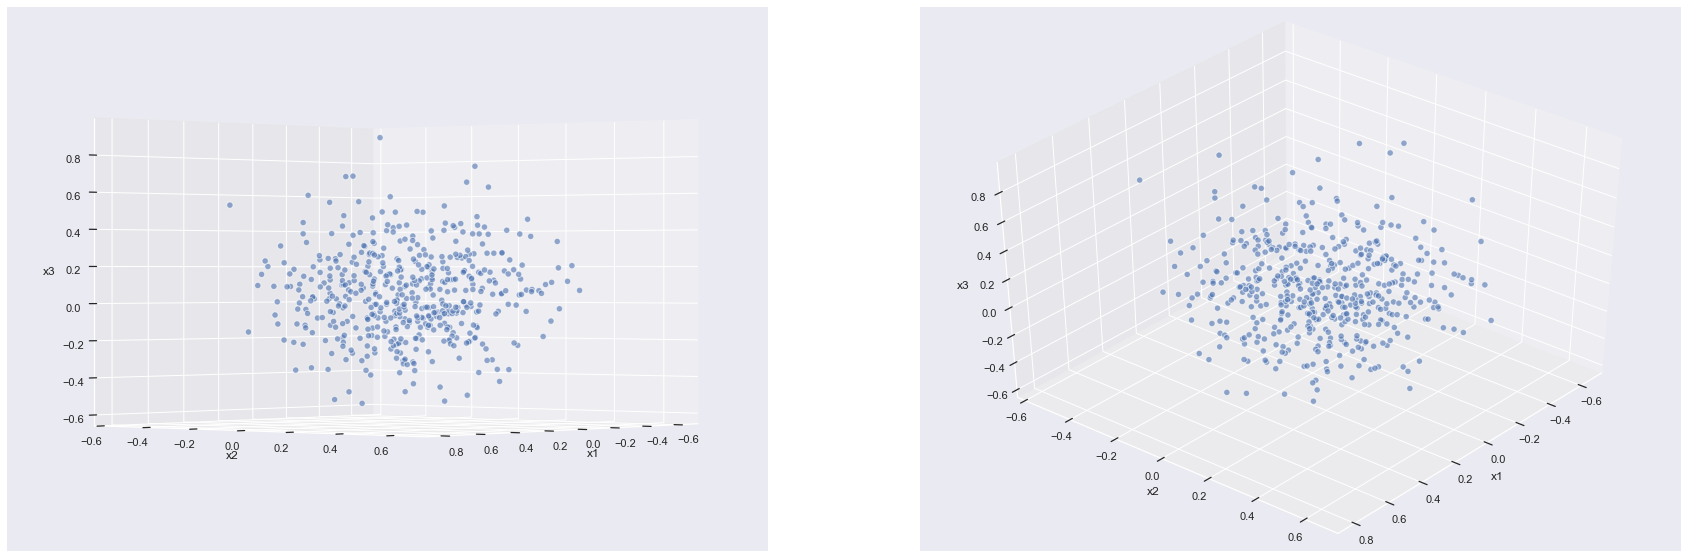

In [3]:
N = 500
x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
xs = x[:,0]; ax.set_xlabel('x1')
ys = x[:,1]; ax.set_ylabel('x2')
zs = x[:,2]; ax.set_zlabel('x3')
ax.scatter(xs, ys, zs, s=40, alpha=0.6, edgecolors='w')
ax.view_init(0, 40)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
xs = x[:,0]; ax2.set_xlabel('x1')
ys = x[:,1]; ax2.set_ylabel('x2')
zs = x[:,2]; ax2.set_zlabel('x3')
ax2.scatter(xs, ys, zs, s=40, alpha=0.6, edgecolors='w')
ax2.view_init(40, 40)

plt.show()

#### Función de optimización (para Frontera Eficiente): minimizar varianza sujeto a restricciones de retorno y de los weights

In [7]:
def find_optimo_merton(r_expected, params):
    Σ_actual = params['Σ_actual']
    μ_actual = params['μ_actual']
    w = np.ones(Σ_actual.shape[0])
    σ = lambda w: w.dot(Σ_actual.dot(w.T))
    
    # Bounds
    w_bound = [(-1000, 1000) for _ in w]
    
    # Constraints
    w_constraint = ({'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    r_constraint = ({'type': 'eq', 'fun': lambda w: np.dot(μ_actual, w) - r_expected})
    
    # Optimization
    optimal_w = scipy.optimize.minimize(σ, w, method = 'SLSQP', 
                                        constraints = [w_constraint, r_constraint], 
                                        bounds = w_bound)
    if optimal_w.success:
        return optimal_w.x
    else:
        raise Exception('Error')

### EJERCICIO 1

In [8]:
μ_actual = np.array([6., 7., 8.])
Σ_actual = np.array([
    [5., -0.1, -0.14],
    [-0.1, 5., -0.12],
    [-0.14, -0.12, 5.]
])
μ_actual = μ_actual / 100.
Σ_actual = Σ_actual / 100.
r_expected = 0.16

##### 1. Utilizando los weights óptimos

Weights:  [-4.17189518  0.34379036  4.82810482]
Expected return (P):  0.15999999999999998
Variance portfolio:  2.096958300653612
Covarianzas activos/portfolio optimo:  [-0.2156979   0.01556769  0.24683335]
Betas:  [-0.10286227  0.00742394  0.11771018]
Ctes:  [0.06932685 0.06932685 0.06932685]


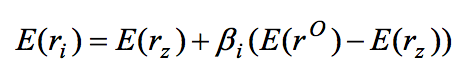

In [9]:
w_opt = find_optimo_merton(r_expected, {'μ_actual': μ_actual, 'Σ_actual': Σ_actual})
cov_ri_popt = Σ_actual.dot(w_opt)
v_port = w_opt.dot(cov_ri_popt)
e_port = w_opt.dot(μ_actual)
betas = cov_ri_popt / v_port
ctes = (μ_actual - betas*(μ_actual.dot(w_opt))) / (1 - betas)
print('Weights: ', w_opt)
print('Expected return (P): ', e_port)
print('Variance portfolio: ', v_port)
print('Covarianzas activos/portfolio optimo: ', cov_ri_popt)
print('Betas: ', betas)
print('Ctes: ', ctes) # => relacion entre cada activo en particular y cualquier portfolio óptimo.

Image(filename='formula.png')
# Esta fórmula es capaz de replicar los retornos esperados del activo i SÓLO SI el portfolio que se usa como benchmark es óptimo

##### Visualización

Text(0.5, 1.0, 'Frontera Eficiente')

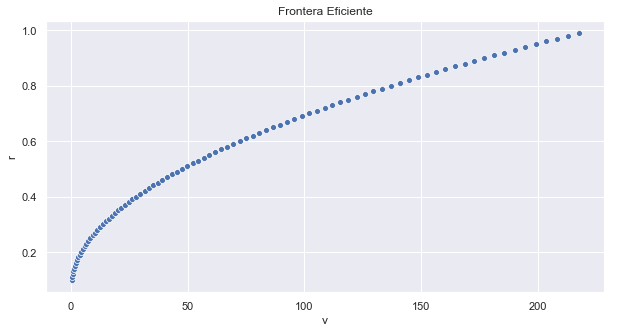

In [111]:
expected_returns = [0.01 * i for i in range(10, 100)]
variances = []
for expected_return in expected_returns:
    # Weights optimos
    w_opt = find_optimo_merton(expected_return, {'μ_actual': μ_actual, 'Σ_actual': Σ_actual})
    # matrix de covarianzas
    cov_ri_popt = Σ_actual.dot(w_opt)
    # Volatility
    v_port = w_opt.dot(cov_ri_popt)
    variances.append(v_port)
# Viz
df = pd.DataFrame(data={'r': expected_returns, 'v': variances})
fig, ax = plt.subplots(figsize=(10, 5), ncols=1, nrows=1)
sns.scatterplot(x='v', y='r', data=df, ax=ax)
ax.set_title('Frontera Eficiente')

##### 2. Utilizando weights no optimos

In [7]:
w_not_opt = w_opt + np.array([3, 0, -1])
cov_ri_popt = Σ_actual.dot(w_not_opt)
v_port = w_not_opt.dot(cov_ri_popt)
e_port = w_not_opt.dot(μ_actual)
betas = cov_ri_popt / v_port
ctes = (μ_actual - betas*(μ_actual.dot(w_not_opt))) / (1 - betas)
print('Weights: ', w_not_opt)
print('Expected return (P): ', e_port)
print('Variance portfolio: ', v_port)
print('Covarianzas activos/portfolio optimo: ', cov_ri_popt)
print('Betas: ', betas)
print('Ctes: ', ctes)

Weights:  [-1.17189518  0.34379036  3.82810482]
Expected return (P):  0.25999999999999995
Variance portfolio:  0.8175042324573808
Covarianzas activos/portfolio optimo:  [-0.0642979   0.01376769  0.19263335]
Betas:  [-0.07865145  0.01684112  0.2356359 ]
Ctes:  [0.07458329 0.06674538 0.02451013]


### Conclusión:
##### Si el portfolio benchmark no es eficiente, entonces la relación lineal se extermina. Los retornos esperados de cada activo riesgoso ya no pueden explicarse por una ecuacion GENERAL y COMÚN (esto es lo que advirtió Roll)
##### La ineficiencia del Benchmark rompe la teoría!

### EJERCICIO 2: M&M + CAPM: ejemplo con 2 activos riesgosos + 1 libre de riesgo

#### Función de optimización (para CAPM)

In [31]:
def find_optimo_capm(params):
    method = params['method']
    risk_free = params['risk_free']
    risk_aversion = params['risk_aversion']
    μ = params['μ']
    Σ = params['Σ']
    expected_return = μ - risk_free
    
    w = np.zeros(Σ.shape[0])
    
    func = lambda w: -1 * (risk_free + expected_return.dot(w) - risk_aversion * w.dot(Σ.dot(w.T)))
    w_constraint = ({'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    res = scipy.optimize.minimize(func, w, method = method)
    if res.success:
        return res.x
    else:
        raise Exception('Error')

### 1. Buscamos Weights correspondientes al portfolio CAPM

In [79]:
w_opt_capm = find_optimo_capm({
    'method': 'L-BFGS-B',
    'μ' : np.array([0.07, 0.04]),
    'Σ' : np.array([
        [0.07, -0.01],
        [-0.01, 0.09]
    ]),
    'risk_free' : 0.05,
    'risk_aversion' : 0.5
})
w_opt_capm

array([ 0.27419354, -0.08064517])

### 2. Buscamos Weights correspondientes al portfolio tangente
##### Notar: (risk-free rate == 0) => los weights del portfolio del CAMP son multiplos del portfolio tangente.

In [80]:
r_expected = 0.0825
μ = np.array([0.07, 0.04])
Σ = np.array([
        [0.07, -0.01],
        [-0.01, 0.09]])
W_T = find_optimo_merton(r_expected, {'μ_actual': μ, 'Σ_actual': Σ})
W_T

array([ 1.41666662, -0.41666662])

### Verificación manual: 
#### el cociente entre los w_capm y w_tangente es el mismo para todos los w_i
#### entonces, capm y frontera eficiente usan el mismo ancla!

In [81]:
rounding_decimals = 5
print([round(x, rounding_decimals) for x in w_opt_capm / W_T])

[0.19355, 0.19355]
